<a href="https://colab.research.google.com/github/Shaiq1217/DIP-Project-CXR/blob/main/DIP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Imports for the project**

In [5]:
!pip install ipyplot
import tensorflow as tf
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import os
import random
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import math
import ipyplot
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


Fetching the data

In [32]:
def conv(inputs, filters, pool = True):
  #conv conv maxpool
  c = Conv2D(filters, 3, padding = "same")(inputs)
  c = Dropout(0.25)(c)
  c = Activation("relu")(c)

  c = Conv2D(filters, 3, padding = "same")(inputs)
  c = Dropout(0.25)(c)
  c = Activation("relu")(c)

  if pool == True:
    p = MaxPooling2D(pool_size=(2, 2))(c)
    return c, p
  else:
    return c

def u_net():
  #encoder (going down)
  inputs = Input((512,512,1))

  c1, pool1 = conv(inputs, 32)
  c2, pool2 = conv(pool1, 64)
  c3, pool3 = conv(pool2, 128)
  #c4, pool4 = conv(pool3, 256)

  ## turning back up
  bridge = conv(pool3, 256, pool = False)

  # decode (going up)
  u1 = UpSampling2D((2,2), interpolation = "bilinear")(bridge)
  con = Concatenate()([u1, c3])
  c4 = conv(con, 128, pool = False)

  u2 = UpSampling2D((2,2), interpolation = "bilinear")(c4)
  con = Concatenate()([u2, c2])
  c5 = conv(con, 64, pool = False)

  u3 = UpSampling2D((2,2), interpolation = "bilinear")(c5)
  con = Concatenate()([u3, c1])
  c6 = conv(con, 32, pool = False)

 

  # output layer
  output = Conv2D(1, 1, padding = "same", activation = "sigmoid")(c6)
  return Model(inputs, output)

model = u_net()

model.compile(optimizer=Adam(lr=1e-4), loss=[BinaryCrossentropy(), BinaryCrossentropy()],
                 loss_weights=[0.5,0.5], metrics=['binary_accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 512, 512, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_3 (Dropout)            (None, 512, 512, 32  0           ['conv2d_3[0][0]']               
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Arranging data in Drive

In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
# Archive('./drive/MyDrive/projectData.rar').extractall('./drive/MyDrive/Promject')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.6 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Masks and Images

In [33]:
import glob
import cv2 as cv
def read_all_files(path, return_size):
  files = glob.glob(path + "/*")
  images = []
  for filename in files:
    image = cv.imread(filename, 0)
    image = cv.resize(image, return_size)
    images.append(image)
  return np.array(images, dtype=np.uint8)
 

images = read_all_files("/content/drive/MyDrive/DIP project/Data/For Project/Segmentation/Training Data/images", (512, 512))
masks = read_all_files("/content/drive/MyDrive/DIP project/Data/For Project/Segmentation/Training Data/masks", (512, 512))
masks = masks/255.0
masks = masks > 0.5
images = images/255.0
images = np.expand_dims(images, axis=-1)

In [ ]:
print(images.shape)
print(masks.shape)

(762, 512, 512, 1)
(762, 512, 512)


# Visualizing Data


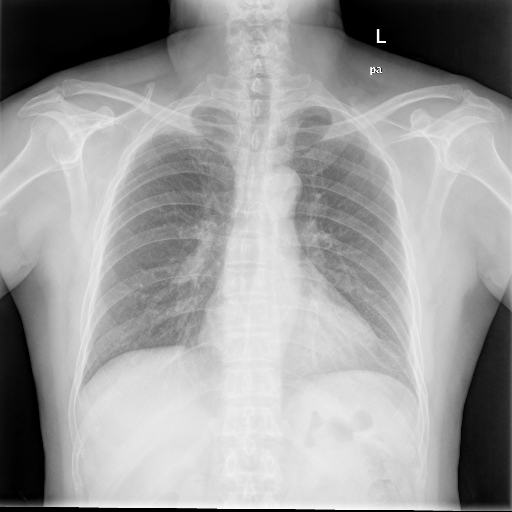
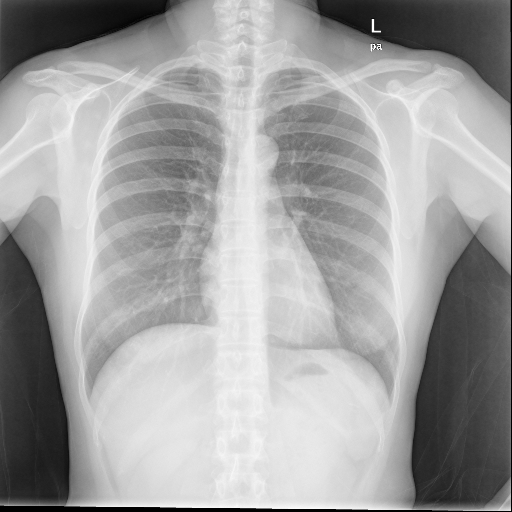
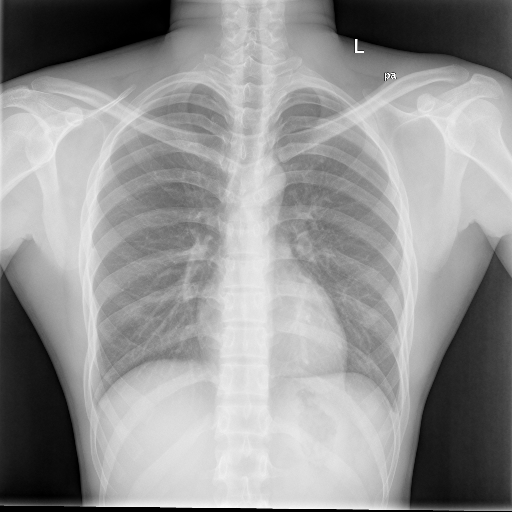
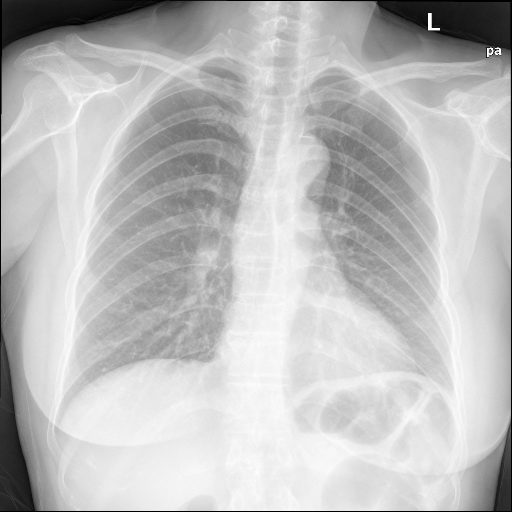
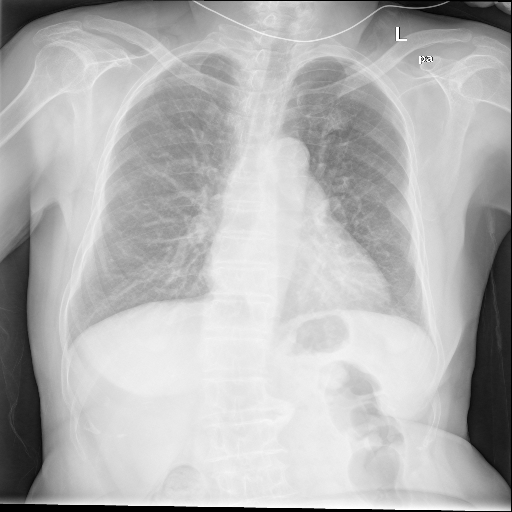
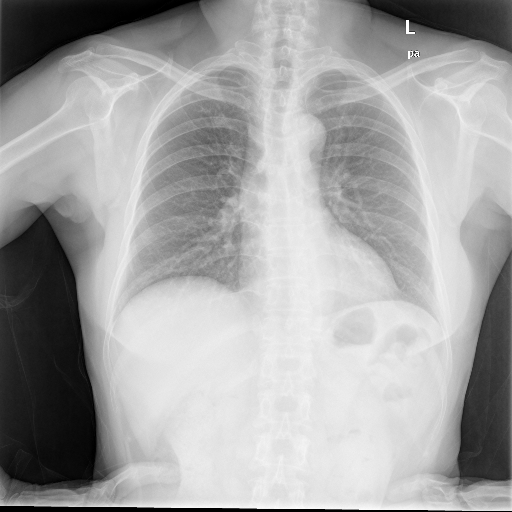
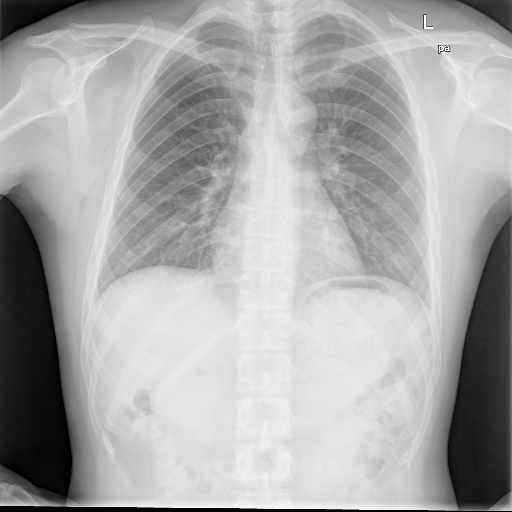
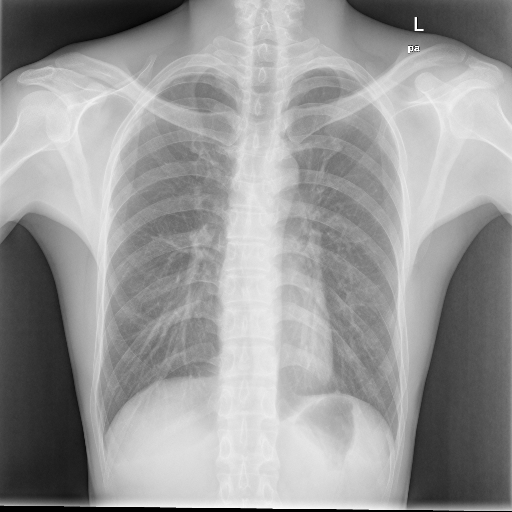
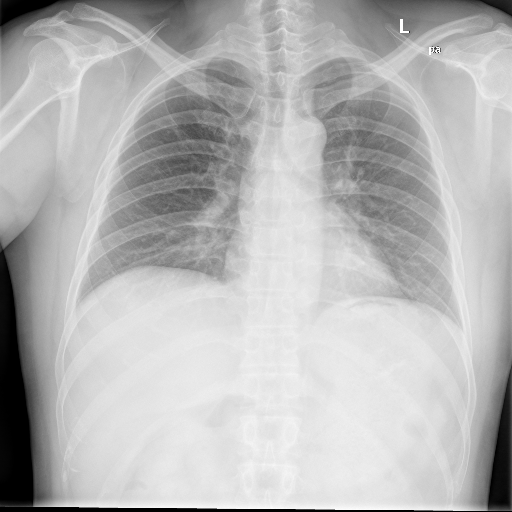
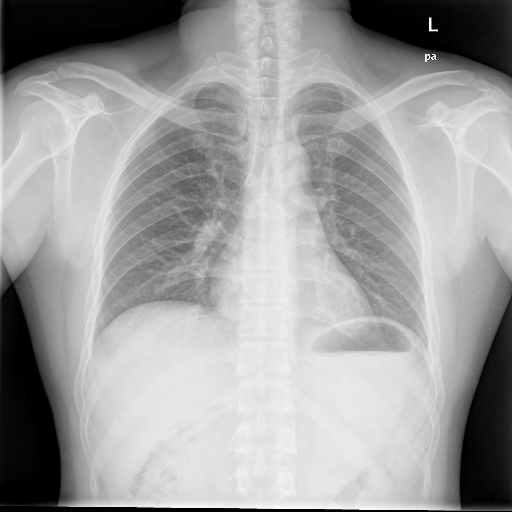


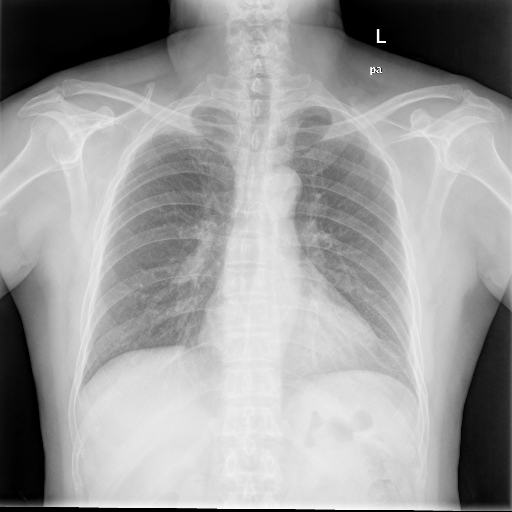
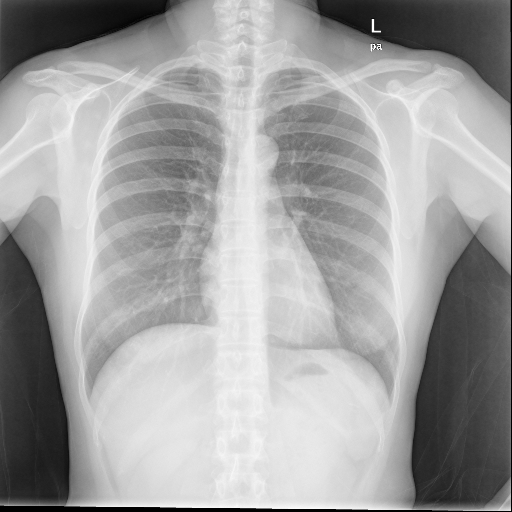
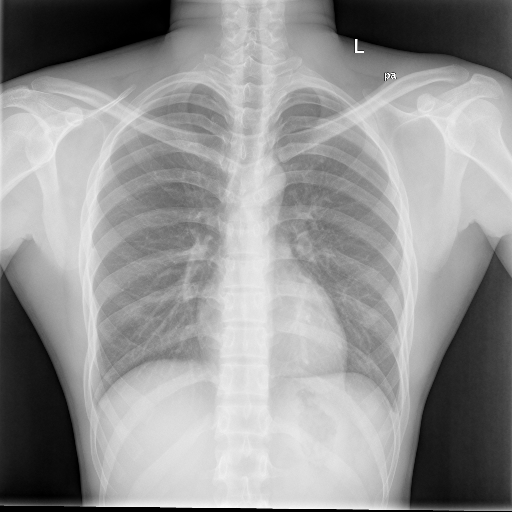
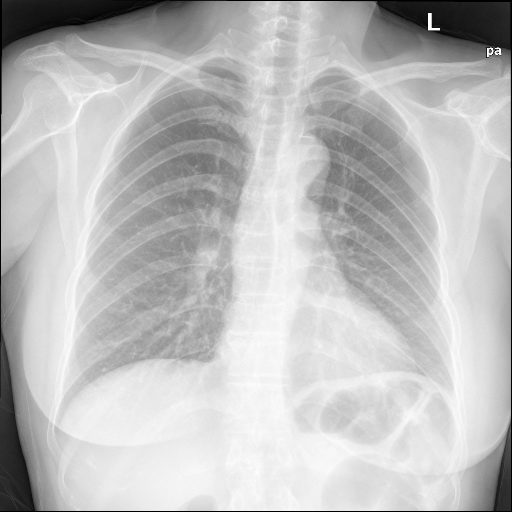
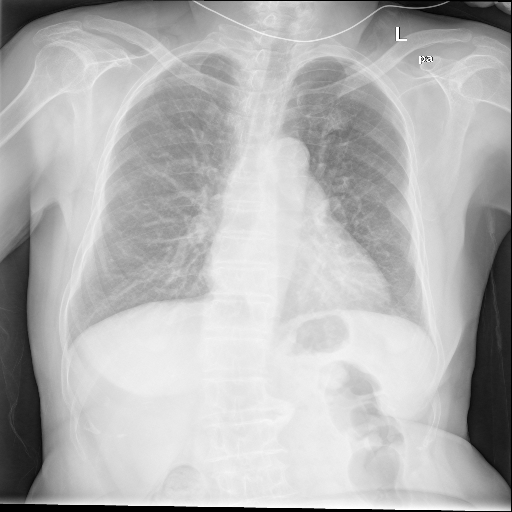
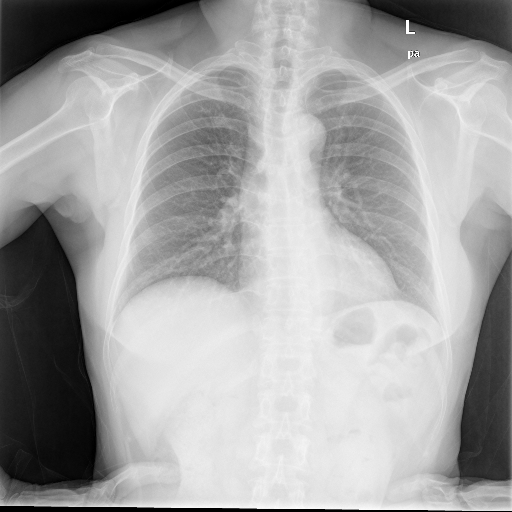
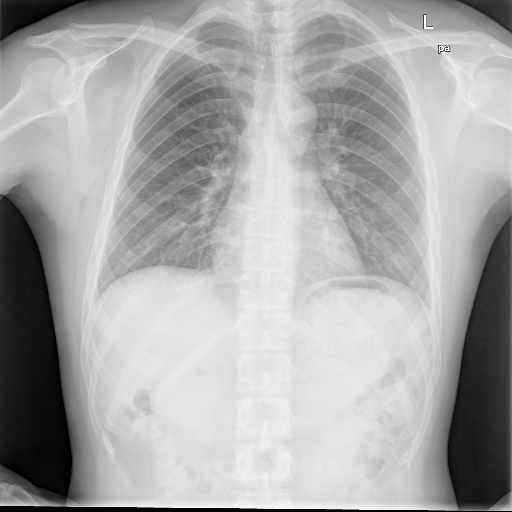
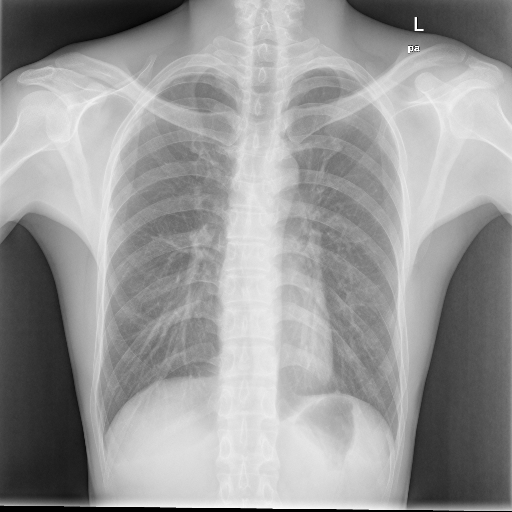
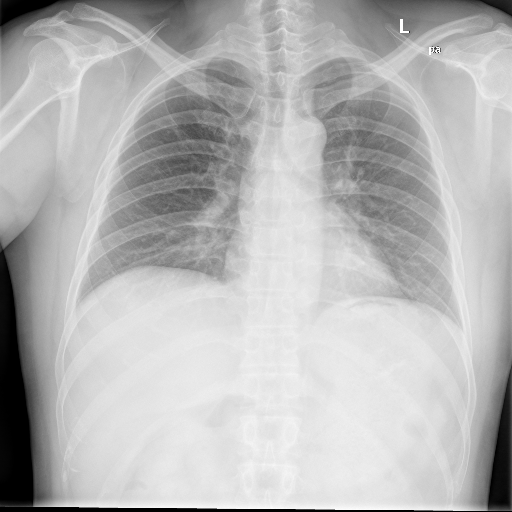
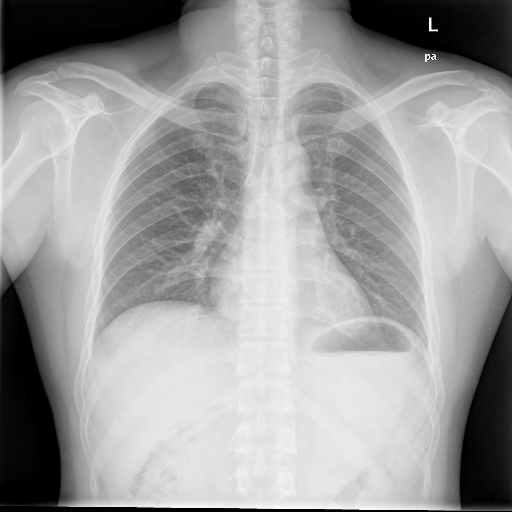


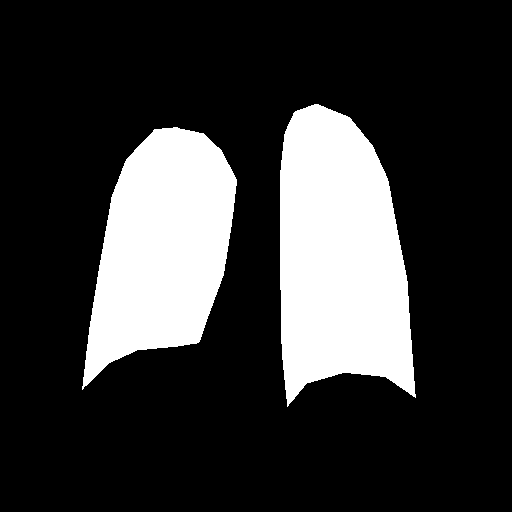
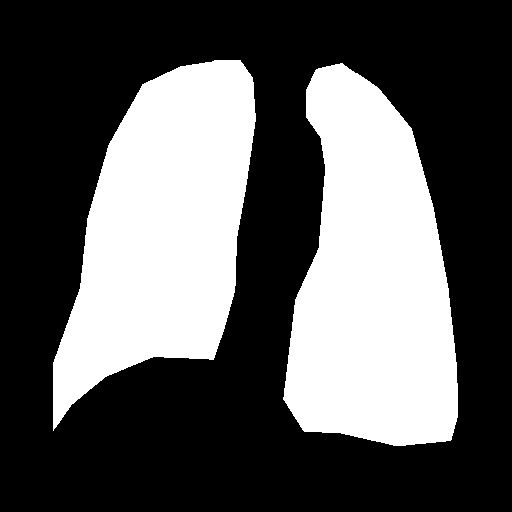
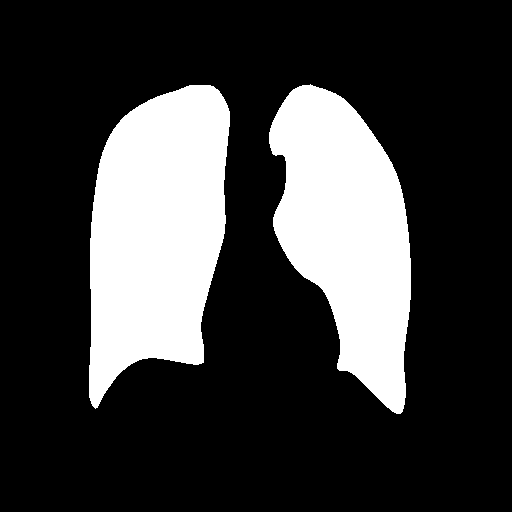
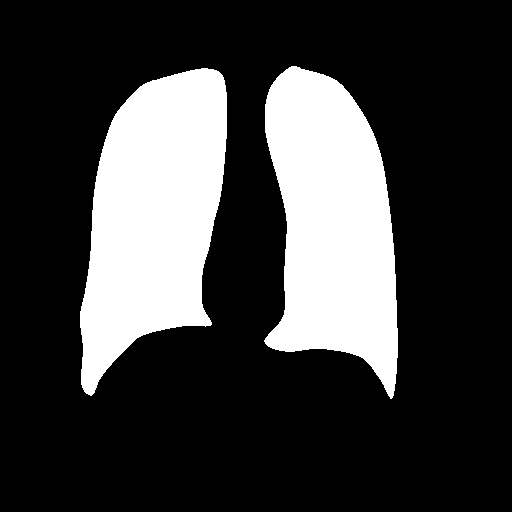
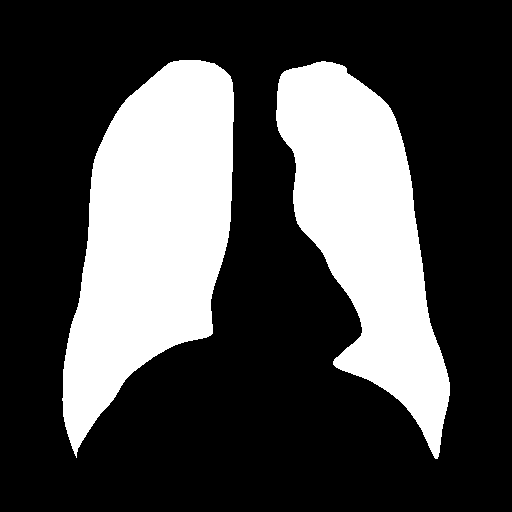
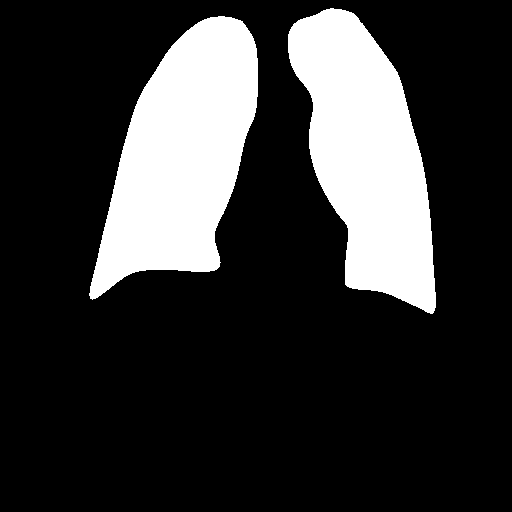
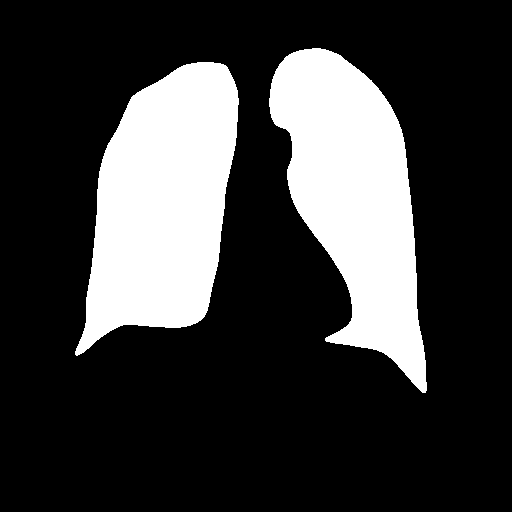
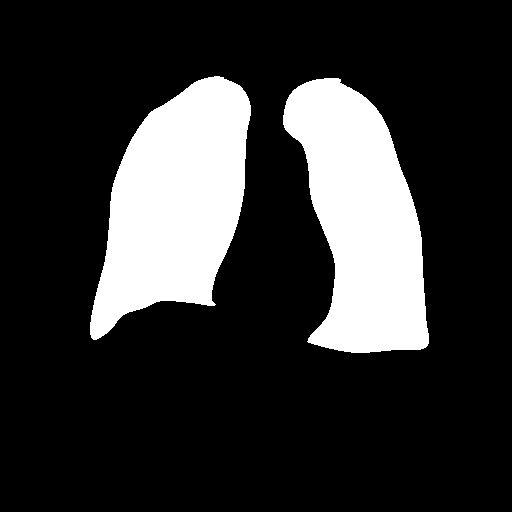
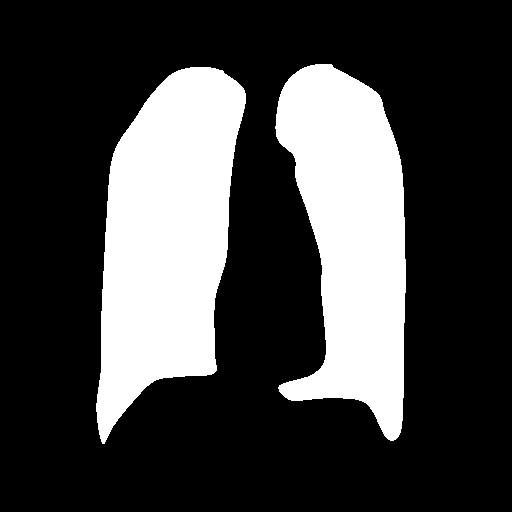
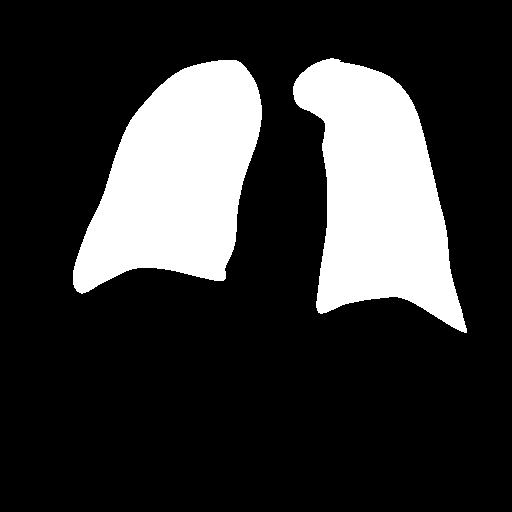


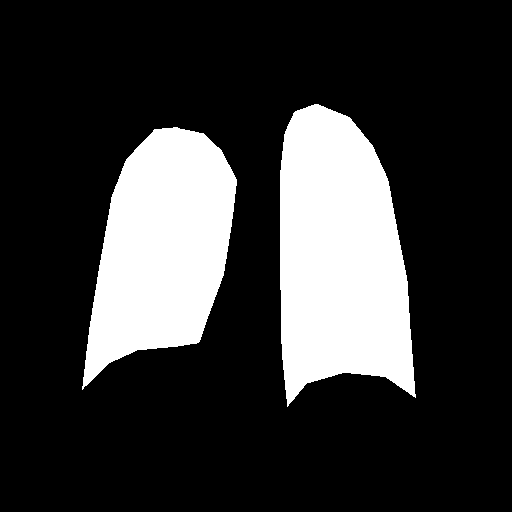
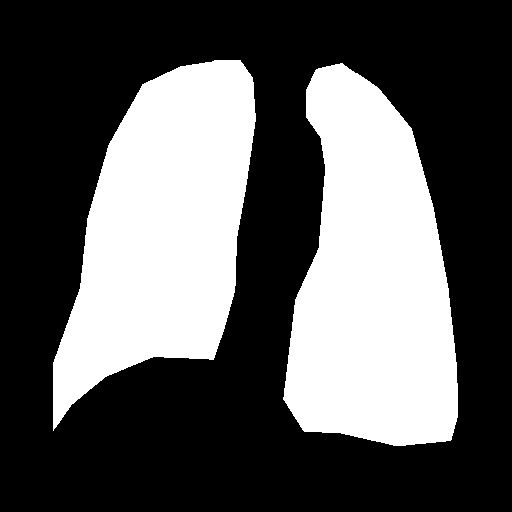
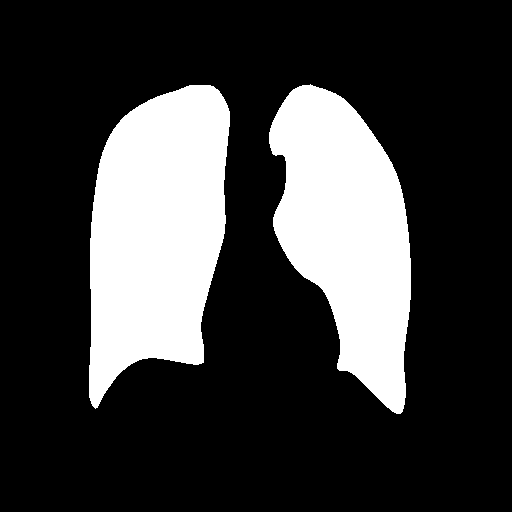
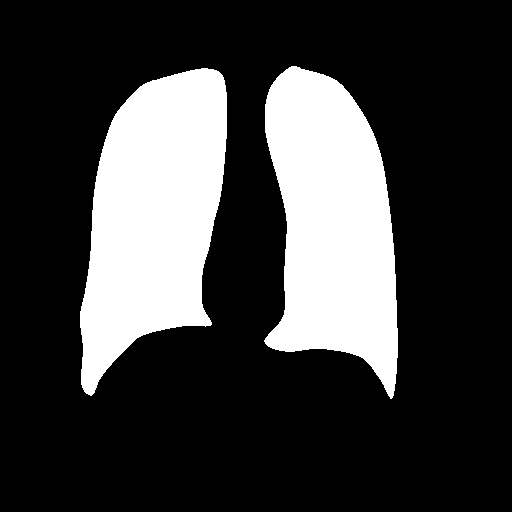
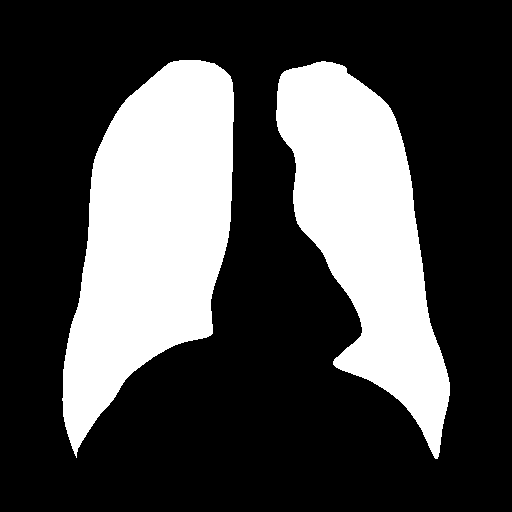
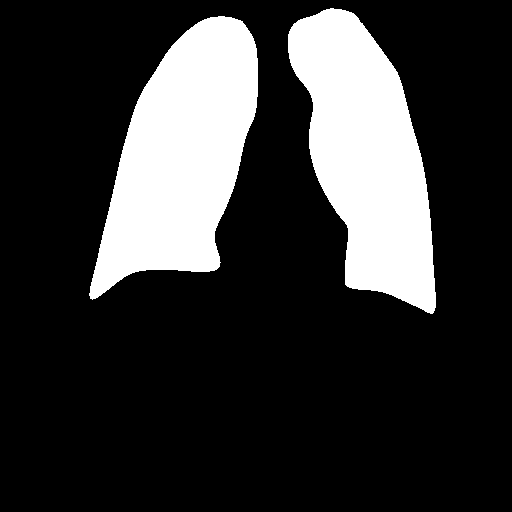
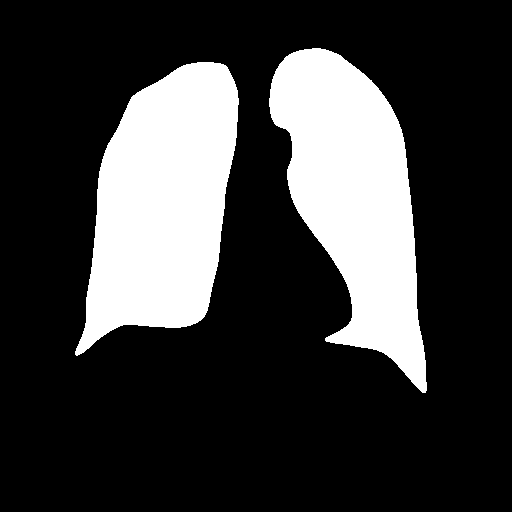
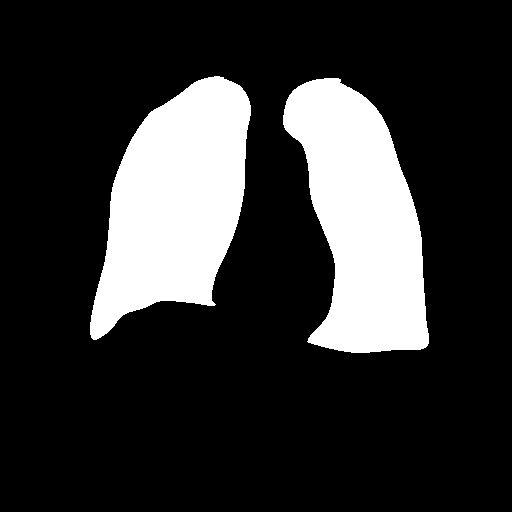
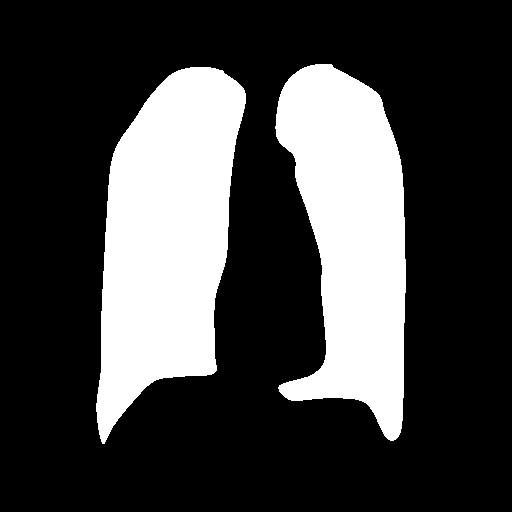
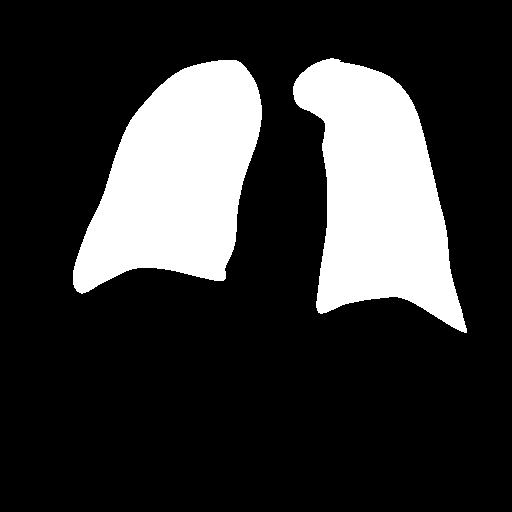

In [ ]:
ipyplot.plot_images(images[:,:,:,0], max_images=10, img_width=150)
ipyplot.plot_images(masks, max_images=10, img_width=150)

# Defining Callbacks

In [34]:
def decaying_cosine_annealing_scheduler(epoch):

    learning_rate_min = 1e-6
    original_learning_rate_max = 1e-3
    original_cycle_length = 15
    epochs_per_cycle = original_cycle_length-(int(epoch/original_cycle_length))
    learning_rate_max = original_learning_rate_max/((int(epoch/original_cycle_length))+1)

    return learning_rate_min + (learning_rate_max - learning_rate_min) * \
           (1 + math.cos(math.pi * (epoch % epochs_per_cycle) / epochs_per_cycle)) / 2



file_path = '/content/drive/MyDrive/DIP project/modelData/model_seg.h5'
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor= 'val_loss', save_best_only=True, save_freq='epoch')
    
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(decaying_cosine_annealing_scheduler, verbose=True)
    
my_callbacks = [checkpoints_callback, learning_rate_callback]

# Training

In [35]:
epochs = 15

print('Training...')
model_history = model.fit(x=images, y=masks, epochs=epochs, callbacks = my_callbacks, validation_split = 0.1, batch_size = 4)


Training...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/15
172/172 [==============================] - 45s 231ms/step - loss: 0.2208 - binary_accuracy: 0.7900 - val_loss: 0.3939 - val_binary_accuracy: 0.6014 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000989084726566536.
Epoch 2/15
172/172 [==============================] - 39s 225ms/step - loss: 0.1921 - binary_accuracy: 0.8375 - val_loss: 0.3128 - val_binary_accuracy: 0.6524 - lr: 9.8908e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009568159560924792.
Epoch 3/15
172/172 [==============================] - 39s 224ms/step - loss: 0.1840 - binary_accuracy: 0.8433 - val_loss: 0.3480 - val_binary_accuracy: 0.6387 - lr: 9.5682e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009046039886902864.
Epoch 4/15
172/172 [==============================] - 39s 224ms/step - loss: 0.1769 - binary_accuracy: 0.8501 - val_loss: 0.3532 - val_binary_accuracy: 0.6502 - 

Loading model and Testing

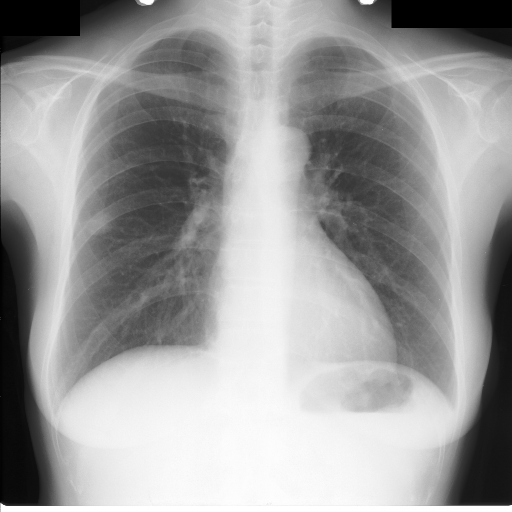

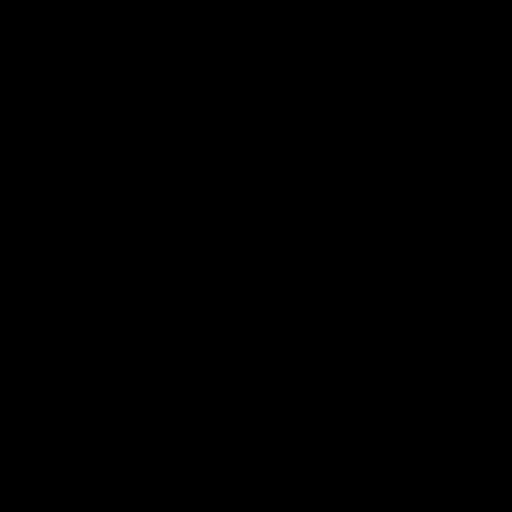

In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
SAVE_PATH = '/content/drive/MyDrive/DIP project/modelData/Seg results'
#getting an image
image = cv.imread('/content/drive/MyDrive/DIP project/Data/For Project/Segmentation/Validation Data/images/JPCLN019.png', 0)

image = cv.resize(image, (512,512))
cv2_imshow(image)
#normalizing
img = image/255.0
#expand dimensions
img = np.expand_dims(img, axis = -1)
img = np.expand_dims(img, axis = 0)

#predicting the mask for this image
pred = model.predict(img)[0]
pred = np.squeeze(pred, axis=-1)

pred = pred.astype(np.int32)
pred = pred*255
#saving the result
cv2_imshow(pred)



Release Memory after Training


In [ ]:
!pip install numba
from numba import cuda 
device = cuda.get_current_device()
device.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Classification**

In [6]:
x = []
y = []
classes = glob.glob("drive/MyDrive/DIP project/Data/For Project/Classification/Training/*")

for i in range(len(classes)):
  temp_y = np.zeros(len(classes), dtype=np.float32)
  temp_y[i] = 1.0
  img_names = glob.glob(classes[i] + "/*")
  for img_name in img_names:
    img = cv.imread(img_name, 0)
    img = cv.resize(img, (176, 176))
    img = img.astype(np.float32)
    img = img/255.0
    img = np.expand_dims(img, axis=-1)
    x.append(img)
    y.append(temp_y)

x = np.array(x)
y = np.array(y)
print(y.shape)
np.save("/content/drive/MyDrive/DIP project/modelData/training_classification_image.npy", x)
np.save("/content/drive/MyDrive/DIP project/modelData/training_classification_label.npy", y)



(1500, 6)


Model building and compiling

In [7]:
def best_model_ever(input_size, classes):
  inputs = Input(input_size)

  c1 = Conv2D(64, 3, padding = "same")(inputs)
  c1 = Dropout(0.25)(c1)
  c1 = Activation("relu")(c1)

  p1 = MaxPooling2D()(c1)

  c2 = Conv2D(128, 3, padding = "same")(p1)
  c2 = Dropout(0.25)(c2)
  c2 = Activation("relu")(c2)

  p2 = MaxPooling2D()(c2)

  f = Flatten()(p2)

  d1 = Dense(128, activation="relu")(f)
  outputs = Dense(classes, activation="softmax")(d1)
  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=Adam(lr=1e-4), loss=['categorical_crossentropy'],
                 loss_weights=[0.5,0.5], metrics=['categorical_accuracy'])
  return model

model = best_model_ever((176, 176, 1), len(classes))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 176, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 176, 176, 64)      640       
                                                                 
 dropout (Dropout)           (None, 176, 176, 64)      0         
                                                                 
 activation (Activation)     (None, 176, 176, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 128)       73856     
                                                             

Defining Callbacks and running epochs

In [9]:
#callbacks
epochs = 20

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/DIP project/best_save_model.h5", save_best_only = True),
]
model.fit(
    x = x, y = y, epochs=epochs, callbacks=callbacks, validation_split=0.1
)



Epoch 1/20
43/43 [==============================] - 8s 131ms/step - loss: 0.8323 - categorical_accuracy: 0.2630 - val_loss: 0.9572 - val_categorical_accuracy: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 4s 84ms/step - loss: 0.7846 - categorical_accuracy: 0.3081 - val_loss: 0.9750 - val_categorical_accuracy: 0.0067
Epoch 3/20
43/43 [==============================] - 5s 113ms/step - loss: 0.7542 - categorical_accuracy: 0.3622 - val_loss: 0.8389 - val_categorical_accuracy: 0.1933
Epoch 4/20
43/43 [==============================] - 4s 84ms/step - loss: 0.7211 - categorical_accuracy: 0.4207 - val_loss: 0.9889 - val_categorical_accuracy: 0.0533
Epoch 5/20
43/43 [==============================] - 4s 86ms/step - loss: 0.6897 - categorical_accuracy: 0.4400 - val_loss: 1.0024 - val_categorical_accuracy: 0.0933
Epoch 6/20
43/43 [==============================] - 5s 114ms/step - loss: 0.6570 - categorical_accuracy: 0.4726 - val_loss: 0.8234 - val_categorical_accuracy: 0.2533
Epo

Predictive Analysis

In [13]:
import tensorflow as tf
import numpy as np
import cv2 as cv
model = tf.keras.models.load_model("/content/drive/MyDrive/DIP project/save_model.h5")
img = cv.imread("/content/drive/MyDrive/DIP project/Data/For Project/Segmentation/Training Data/images/CHNCXR_0011_0.png", 0)
img = np.expand_dims(np.expand_dims(cv.resize(img, (176, 176)), axis=0), axis=-1)
out = model.predict(img)
print(out)
print(np.max(out))

[[4.349767e-32 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]]
1.0


Confusion Matrix

(1500, 6)


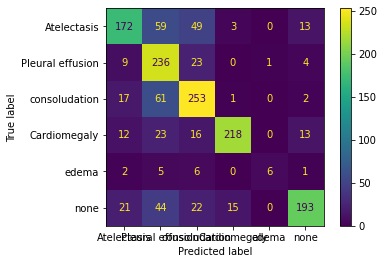

In [16]:
import matplotlib
pred = model.predict(x)

print(pred.shape)
cmd = ConfusionMatrixDisplay((confusion_matrix(list(np.argmax(y, axis=1)), list(np.argmax(pred, axis=1)))), display_labels=['Atelectasis', 'Pleural effusion','consoludation' ,'Cardiomegaly','edema', 'none'])
cmd.plot()
plt.show()